# Deep Learning with PyTorch : Build a Generative Adversarial Network

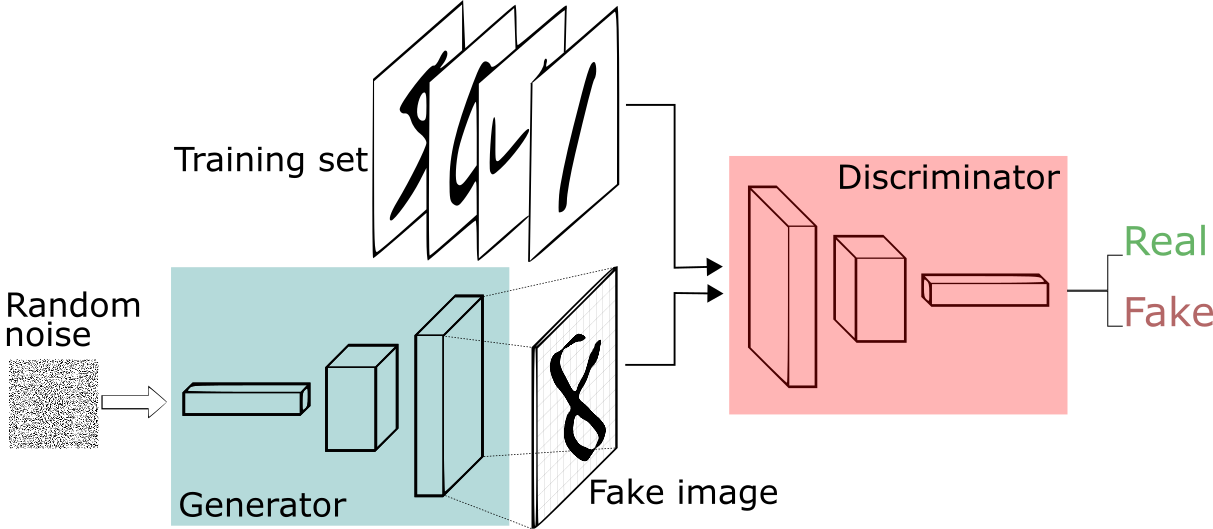

In [ ]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [ ]:
device = 'cuda' #image = image.to(device)
batch_size = 128  # trainloader, training loop
noise_dim = 128 # generator model

#optimzer parameters
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

#trainging variables

epochs = 20

# Load MNIST Dataset

In [ ]:
pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dhruv29soni
Your Kaggle Key: ··········


100%|██████████| 395M/395M [00:04<00:00, 89.0MB/s]


In [ ]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
trainset = ImageFolder(DATA_DIR, transform = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))
trainloader = DataLoader(trainset, batch_size, shuffle = True, num_workers = 3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# image, label = trainsets[500]
# plt.imshow(image.squeeze())

In [ ]:
len(trainset)

63565

# Load Dataset Into Batches

In [ ]:

from torchvision.utils import make_grid


In [ ]:
# trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)

In [ ]:
len(trainloader)

497

In [ ]:
dataiter = iter(trainloader)
images, _  = next(dataiter)
images.shape

torch.Size([128, 3, 64, 64])

In [ ]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

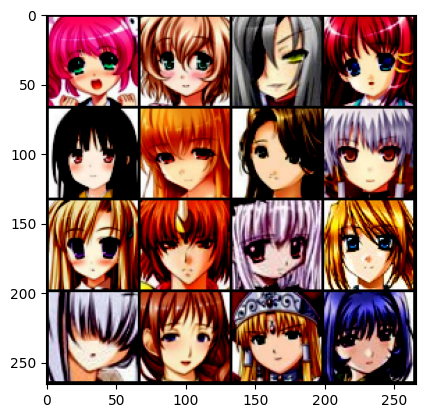

In [ ]:
show_tensor_images(images, num_images = 16)

# Create Discriminator Network

In [ ]:
#In case if torch summary is not installed

#!pip install torchsummary
from torch import nn
from torchsummary import summary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [ ]:
def get_disc_block(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding ),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.block_1 = get_disc_block(3, 64, 4, 2, 1)
    self.block_2 = get_disc_block(64, 128, 4, 2, 1)
    self.block_3 = get_disc_block(128, 256, 4, 2, 1)
    self.block_4 = get_disc_block(256, 512, 4, 2, 1)
    self.block_5 = nn.Sequential(nn.Conv2d(512, 1, 1, 1, 0))

    self.flatten = nn.Flatten()
    self.Sigmoid = nn.Sigmoid()

  def forward(self, images):
    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)
    x5 = self.block_5(x4)

    x6 = self.flatten(x5)
    x7 = self.Sigmoid(x6)
    return x7

In [ ]:
D = Discriminator()
D.to(device)

summary(D, input_size = (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,136
       BatchNorm2d-2           [-1, 64, 14, 14]             128
         LeakyReLU-3           [-1, 64, 14, 14]               0
            Conv2d-4            [-1, 128, 7, 7]         131,200
       BatchNorm2d-5            [-1, 128, 7, 7]             256
         LeakyReLU-6            [-1, 128, 7, 7]               0
            Conv2d-7            [-1, 256, 3, 3]         524,544
       BatchNorm2d-8            [-1, 256, 3, 3]             512
         LeakyReLU-9            [-1, 256, 3, 3]               0
           Conv2d-10            [-1, 512, 1, 1]       2,097,664
      BatchNorm2d-11            [-1, 512, 1, 1]           1,024
        LeakyReLU-12            [-1, 512, 1, 1]               0
           Conv2d-13              [-1, 1, 1, 1]             513
          Flatten-14                   

# Create Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                                 

In [ ]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, padding, final_block = False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [ ]:
class Generator(nn.Module):
  def __init__(self, noise_dim):
    super(Generator, self).__init__()

    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim, 512, 4, 1, 0)
    self.block_2 = get_gen_block(512, 256, 4, 2, 1)
    self.block_3 = get_gen_block(256, 128, 4, 2, 1)
    self.block_4 = get_gen_block(128, 64, 4, 2, 1)

    self.block_5 = get_gen_block(64, 3, 4, 2, 1, final_block=True)

  def forward(self, r_noise_vec):
    #(bs, noise_dim) -> (bs, noise_dim, 1, 1)
    x = r_noise_vec.view(-1, self.noise_dim, 1, 1)

    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)
    x5 = self.block_5(x4)


    return x5

In [ ]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size = (3, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,049,088
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,408
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,416
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,136
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,075
             Tanh-14            [-1, 3,

In [ ]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [ ]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [ ]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion (disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion (disc_pred, ground_truth)
  return loss

In [ ]:
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta_1, beta_2))

# Training Loop

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 1 | D_loss: 0.6685373128299982 | G_loss: 0.573433815893273


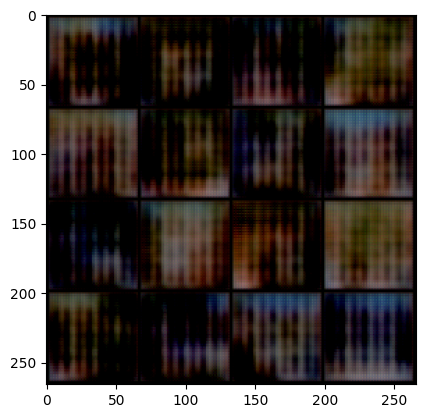

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 2 | D_loss: 0.6134259368572197 | G_loss: 0.6491284820155598


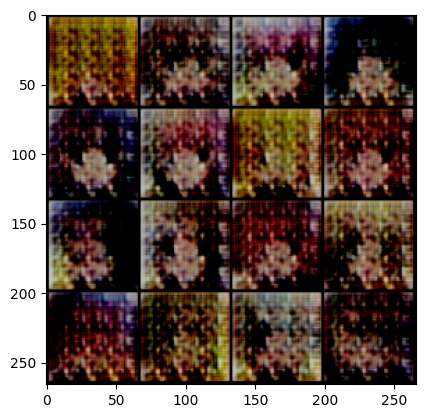

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 3 | D_loss: 0.6157672399246477 | G_loss: 0.6629108429194935


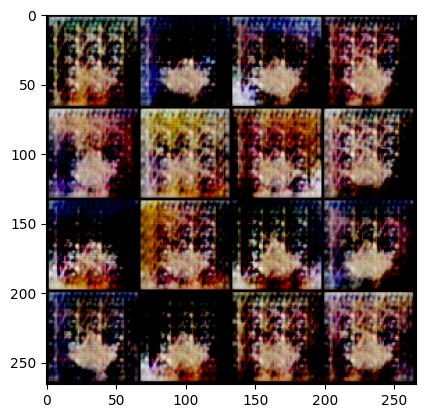

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 4 | D_loss: 0.6282098223745703 | G_loss: 0.641345881720184


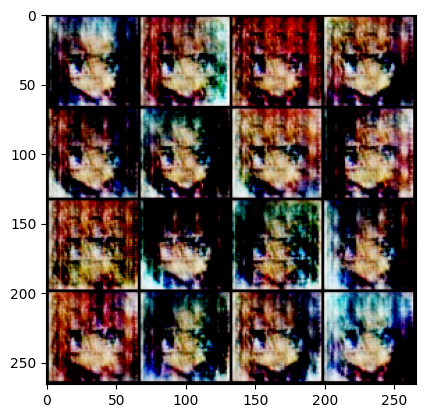

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 5 | D_loss: 0.6026023411654851 | G_loss: 0.6501298164817649


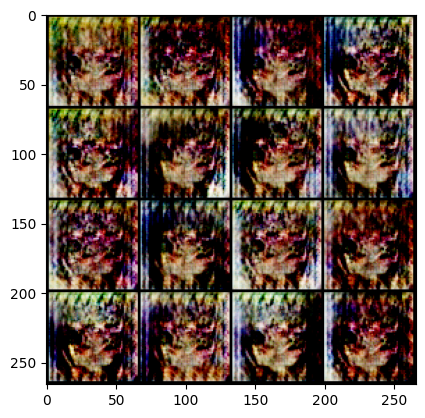

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 6 | D_loss: 0.598015653415465 | G_loss: 0.639329675997287


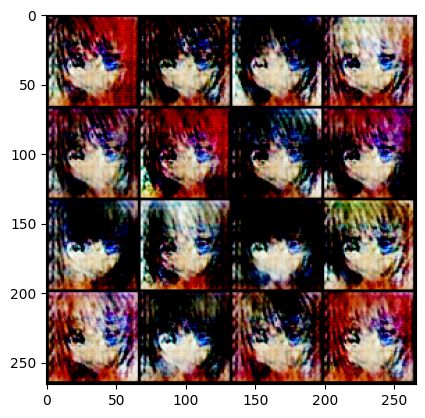

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 7 | D_loss: 0.6264744945455125 | G_loss: 0.5997260289652726


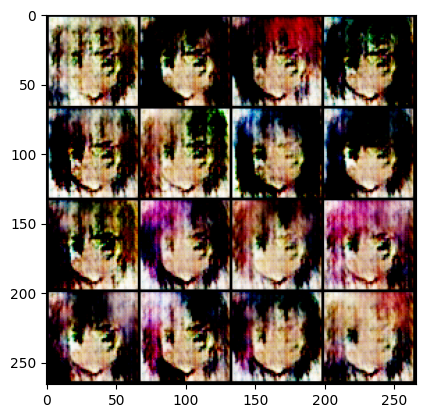

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 8 | D_loss: 0.6030820995509265 | G_loss: 0.6291196882964619


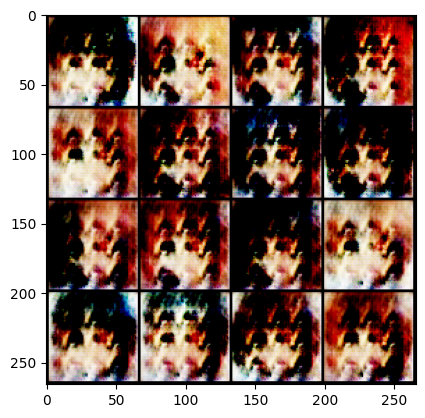

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 9 | D_loss: 0.6266821679215077 | G_loss: 0.6420292212689667


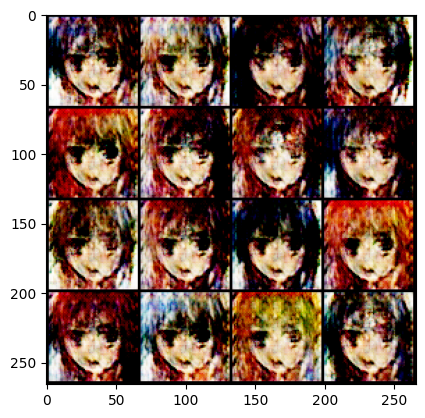

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 10 | D_loss: 0.6926218471536694 | G_loss: 0.5099138887955149


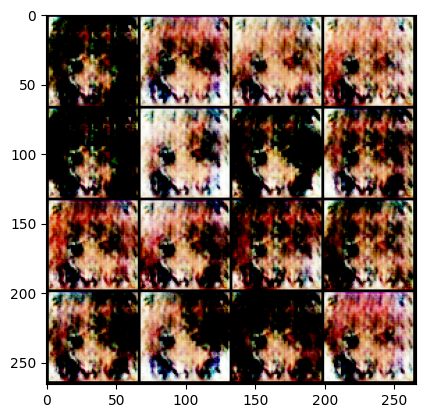

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 11 | D_loss: 0.6729229145366661 | G_loss: 0.5327676034549352


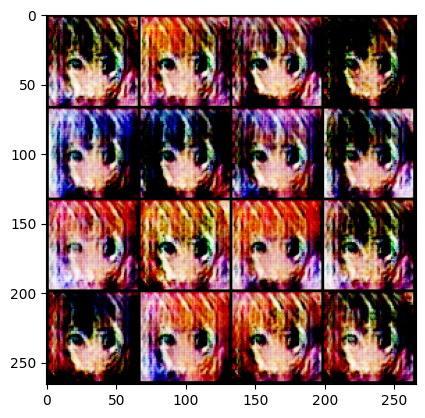

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 12 | D_loss: 0.7103067830774625 | G_loss: 0.48539467039002737


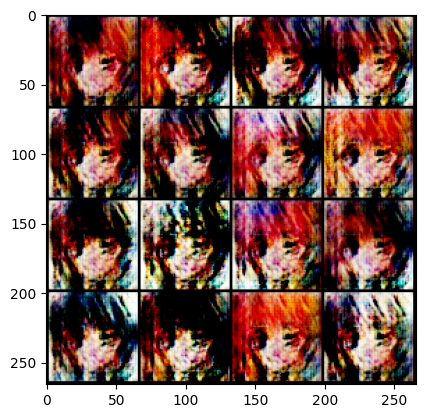

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 13 | D_loss: 0.7070190962891224 | G_loss: 0.49345220898238706


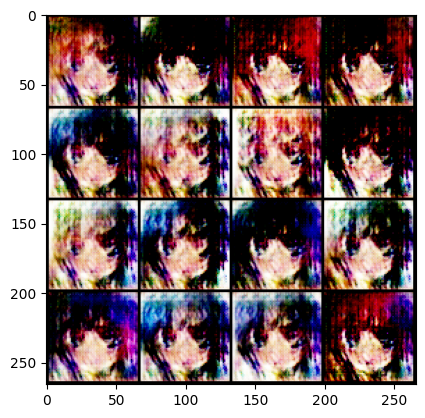

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 14 | D_loss: 0.683959793157021 | G_loss: 0.5194016916890979


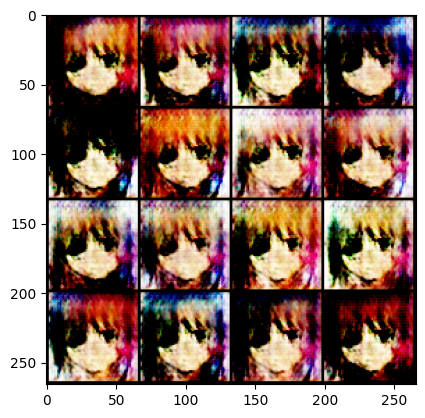

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 15 | D_loss: 0.6593188937281219 | G_loss: 0.5495229007252745


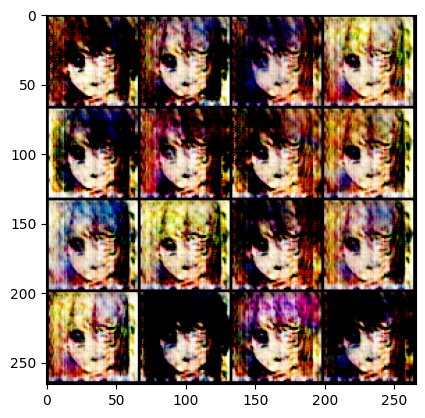

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 16 | D_loss: 0.6103330922558514 | G_loss: 0.611769642688379


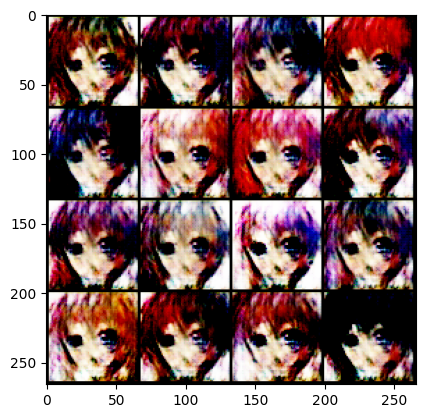

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 17 | D_loss: 0.6258626122110087 | G_loss: 0.587726956521961


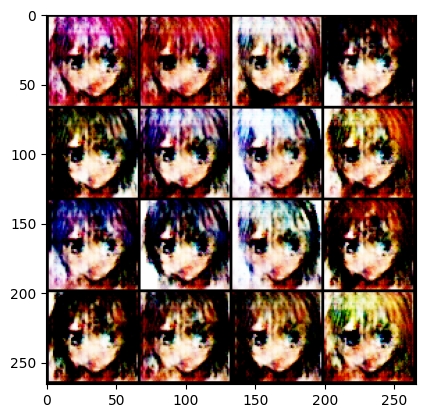

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 18 | D_loss: 0.7257980873407253 | G_loss: 0.46785697083118216


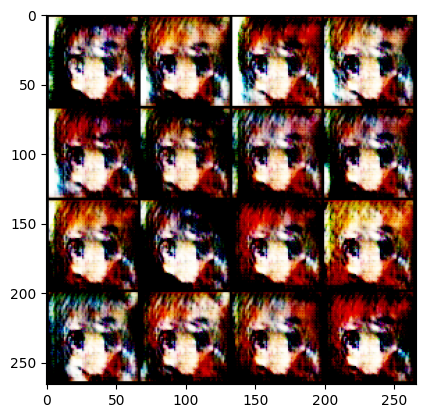

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 19 | D_loss: 0.6441514614362353 | G_loss: 0.5701351650883734


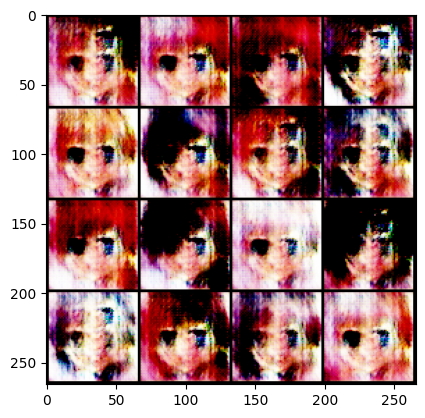

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 20 | D_loss: 0.6047501063922521 | G_loss: 0.6171354032018534


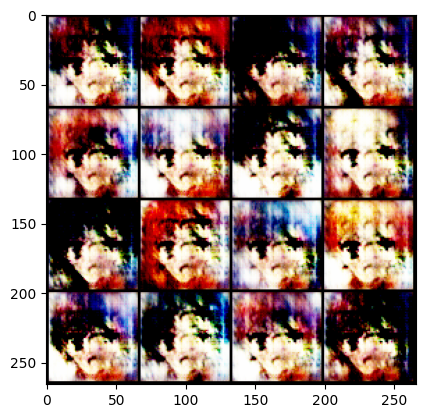

In [ ]:
for i in range(epochs):

  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img, _ in tqdm(trainloader):

    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device = device)

    #find loss and update weights for D

    D_opt.zero_grad()


    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss)/2

    total_d_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()

    #find loss and update weights for G

    G_opt.zero_grad()

    noise = torch.randn(batch_size, noise_dim, device = device)

    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)

    total_g_loss += G_loss.item()
    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss / len(trainloader)
  avg_g_loss = total_g_loss / len(trainloader)

  print("Epoch: {} | D_loss: {} | G_loss: {}".format(i+1, avg_d_loss, avg_g_loss))

  show_tensor_images(fake_img)

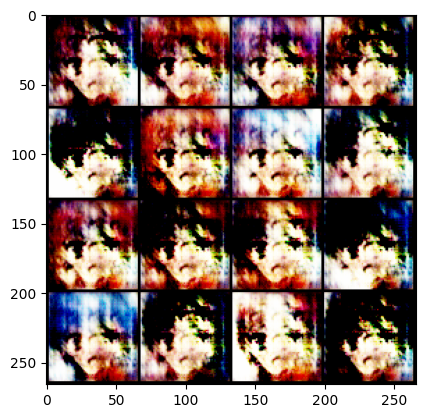

In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)